In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import warnings
import logging
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/dapprojekt24-1/train.csv
/kaggle/input/dapprojekt24-1/test.csv


In [2]:
# Suppress all warnings
warnings.filterwarnings("ignore")

# Disable LightGBM info messages
logging.getLogger('lightgbm').setLevel(logging.ERROR)

# 0. Data loading and basic info

In [3]:
train_data = pd.read_csv("/kaggle/input/dapprojekt24-1/train.csv")
test_data = pd.read_csv("/kaggle/input/dapprojekt24-1/test.csv")

In [4]:
train_data.head()

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume,Target,Id
0,2010-01-04,MMM,53.295380,83.019997,83.449997,82.669998,83.089996,3043700.0,0,0
1,2010-01-05,MMM,52.961575,82.500000,83.230003,81.699997,82.800003,2847000.0,0,1
2,2010-01-06,MMM,53.712681,83.669998,84.599998,83.510002,83.879997,5268500.0,0,2
3,2010-01-07,MMM,53.751179,83.730003,83.760002,82.120003,83.320000,4470100.0,0,3
4,2010-01-08,MMM,54.129955,84.320000,84.320000,83.300003,83.690002,3405800.0,0,4


In [5]:
symbols = train_data['Symbol'].unique()
symbols


array(['MMM', 'AOS', 'ACN', 'AES', 'A', 'AKAM', 'ALB', 'ALLE', 'LNT',
       'GOOGL', 'MO', 'AMZN', 'AXP', 'AWK', 'AME', 'ANSS', 'APA', 'AAPL',
       'AMAT', 'ADM', 'ANET', 'AIZ', 'T', 'BKR', 'BALL', 'BAC', 'BBY',
       'BIIB', 'BLK', 'BMY', 'AVGO', 'BG', 'CPB', 'CAH', 'CBOE', 'CHRW',
       'CHTR', 'CMG', 'CINF', 'CSCO', 'CFG', 'CME', 'CMS', 'KO', 'CAG',
       'ED', 'STZ', 'CTVA', 'CTRA', 'CMI', 'DVA', 'DE', 'XRAY', 'FANG',
       'DLR', 'DFS', 'DPZ', 'DHI', 'DTE', 'DUK', 'EBAY', 'EMR', 'ENPH',
       'EOG', 'EQIX', 'ESS', 'EL', 'EVRG', 'ES', 'EXPD', 'EXR', 'FFIV',
       'FAST', 'FIS', 'FE', 'FLT', 'FTV', 'FOXA', 'FCX', 'IT', 'GEHC',
       'GEN', 'GNRC', 'GM', 'GPC', 'GL', 'GS', 'HAS', 'PEAK', 'HSY',
       'HES', 'HLT', 'HST', 'HBAN', 'IBM', 'ILMN', 'PODD', 'INTC', 'IFF',
       'IP', 'ISRG', 'IVZ', 'INVH', 'IQV', 'JNJ', 'KVUE', 'KDP', 'KEY',
       'KEYS', 'KMB', 'KIM', 'KMI', 'KR', 'LVS', 'LDOS', 'LIN', 'LMT',
       'LYB', 'MPC', 'MKTX', 'MMC', 'MCD', 'MAA', 'MHK', 'TAP', 'MP

# 1. Data preparation
Here I created two functions, `check_seasonality_strength` and `plot_seasonality`. I use the first one to get the seasonality strength of each individual stock. Since this value ranges between 0 and 1, I add each stock with a factor >= 0.4 to the list `potential`, and visualize it using the second function to verify its seasonality.

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

train_data.dropna(inplace=True) 

def plot_seasonality(df, symbol):
    stock_data = df[df['Symbol'] == symbol]
    stock_data['Date'] = pd.to_datetime(stock_data['Date'])
    period = 365
    if len(stock_data) < 2*period:
        print(f'Skipping {symbol} due to insufficient data ({len(stock_data)} observations)')
        return
    
    result = seasonal_decompose(stock_data['Adj Close'], model='additive', period=period)
    
    result.plot()
    plt.show()
    
def check_seasonality_strength(df, symbol):
    stock_data = df[df['Symbol'] == symbol].copy()
    stock_data['Date'] = pd.to_datetime(stock_data['Date'])

    period = 365
    if len(stock_data) < 2 * period:
        print(f'Symbol {symbol}: skipped due to insufficient data')
        return -1

    result = seasonal_decompose(stock_data['Adj Close'], model='additive', period=period)
    
    residual_var = np.var(result.resid.dropna())
    seasonal_var = np.var(result.seasonal.dropna())
        
    seasonality_strength = seasonal_var / (residual_var+seasonal_var)
    
    print(f'Symbol {symbol}: {seasonality_strength:.3f}')
    return seasonality_strength


In [7]:
potential = []
for symbol in symbols:
    a = check_seasonality_strength(train_data, symbol)
    if a > 0.4: potential.append(symbol)


Symbol MMM: 0.273
Symbol AOS: 0.322
Symbol ACN: 0.210
Symbol AES: 0.150
Symbol A: 0.109
Symbol AKAM: 0.478
Symbol ALB: 0.197
Symbol ALLE: 0.293
Symbol LNT: 0.333
Symbol GOOGL: 0.136
Symbol MO: 0.210
Symbol AMZN: 0.246
Symbol AXP: 0.229
Symbol AWK: 0.397
Symbol AME: 0.175
Symbol ANSS: 0.205
Symbol APA: 0.097
Symbol AAPL: 0.257
Symbol AMAT: 0.226
Symbol ADM: 0.184
Symbol ANET: 0.322
Symbol AIZ: 0.188
Symbol T: 0.128
Symbol BKR: 0.367
Symbol BALL: 0.139
Symbol BAC: 0.279
Symbol BBY: 0.284
Symbol BIIB: 0.109
Symbol BLK: 0.298
Symbol BMY: 0.216
Symbol AVGO: 0.092
Symbol BG: 0.217
Symbol CPB: 0.180
Symbol CAH: 0.104
Symbol CBOE: 0.250
Symbol CHRW: 0.157
Symbol CHTR: 0.136
Symbol CMG: 0.109
Symbol CINF: 0.249
Symbol CSCO: 0.307
Symbol CFG: 0.428
Symbol CME: 0.296
Symbol CMS: 0.321
Symbol KO: 0.201
Symbol CAG: 0.201
Symbol ED: 0.421
Symbol STZ: 0.127
Symbol CTVA: skipped due to insufficient data
Symbol CTRA: 0.157
Symbol CMI: 0.194
Symbol DVA: 0.192
Symbol DE: 0.102
Symbol XRAY: 0.172
Symbol F

['AKAM', 'CFG', 'ED', 'DUK', 'FLT', 'FTV', 'HLT', 'INVH', 'MCD', 'PAYX', 'RF', 'SYF', 'TFC', 'ZTS']

Checking seasonality for AKAM


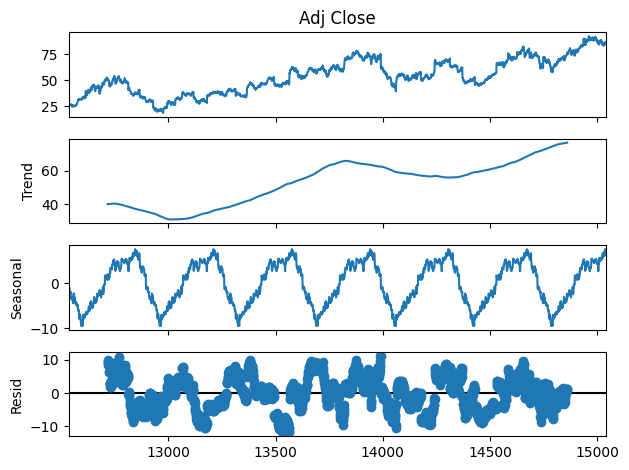


Checking seasonality for CFG


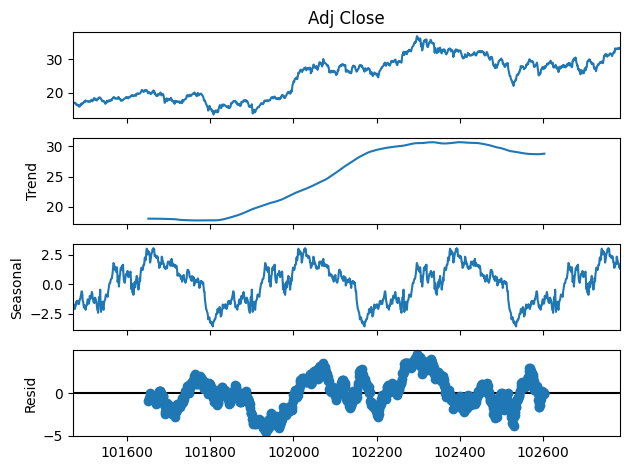


Checking seasonality for ED


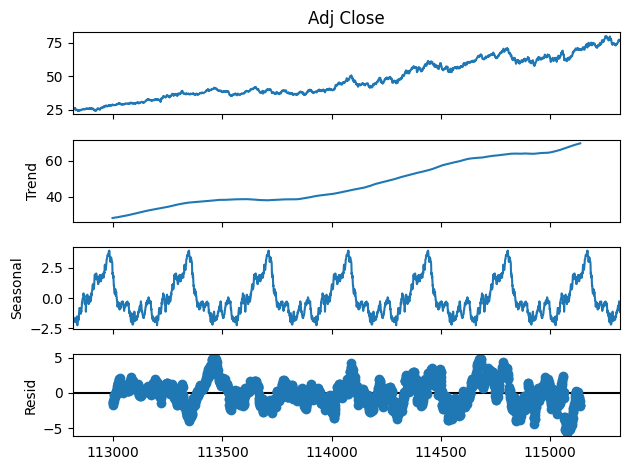


Checking seasonality for DUK


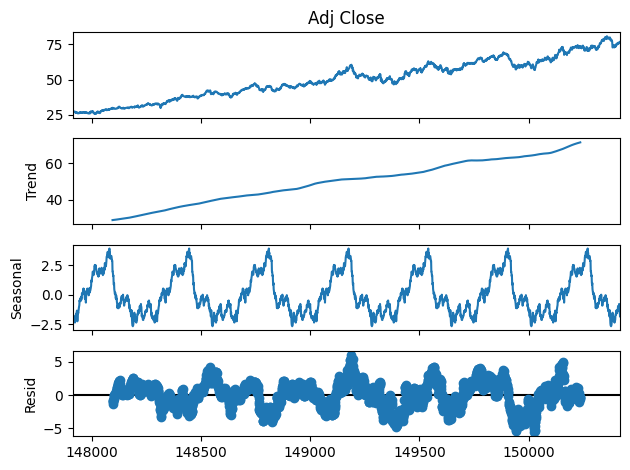


Checking seasonality for FLT


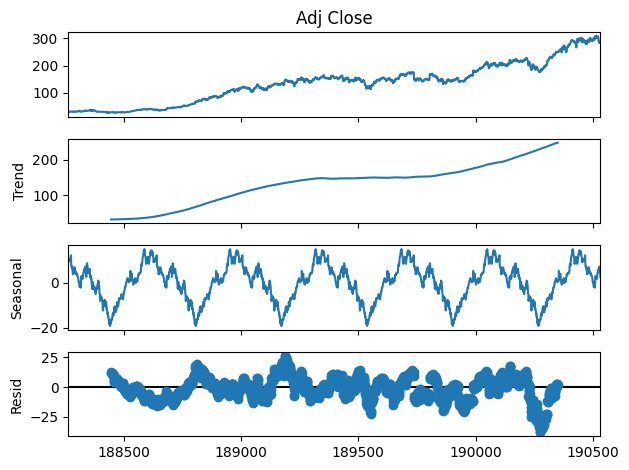


Checking seasonality for FTV


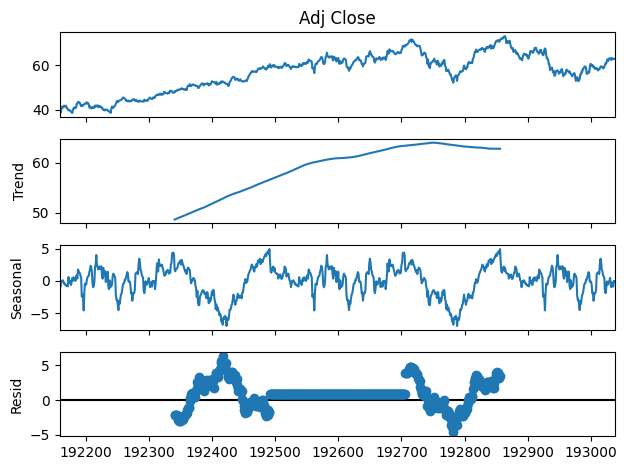


Checking seasonality for HLT


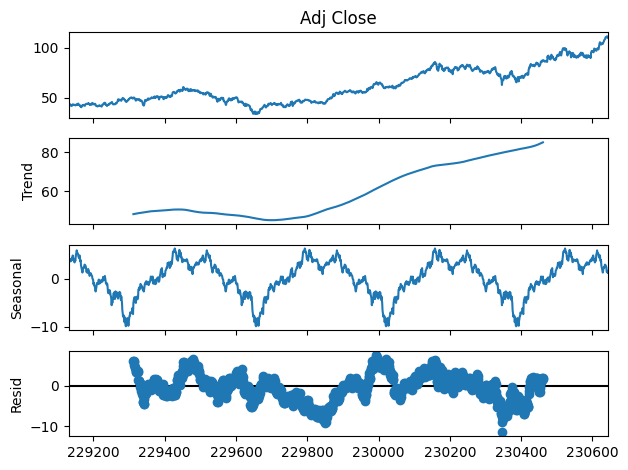


Checking seasonality for INVH


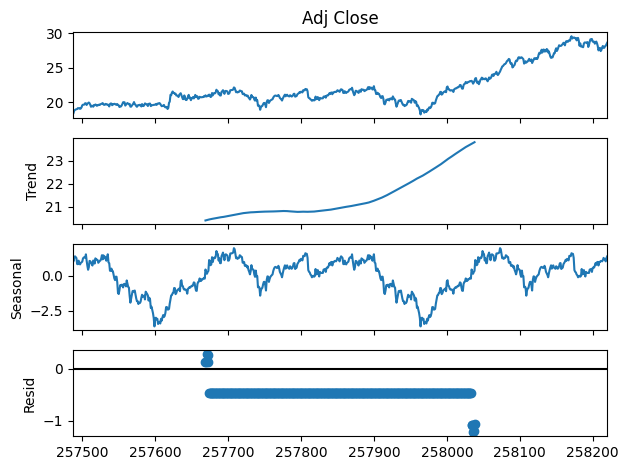


Checking seasonality for MCD


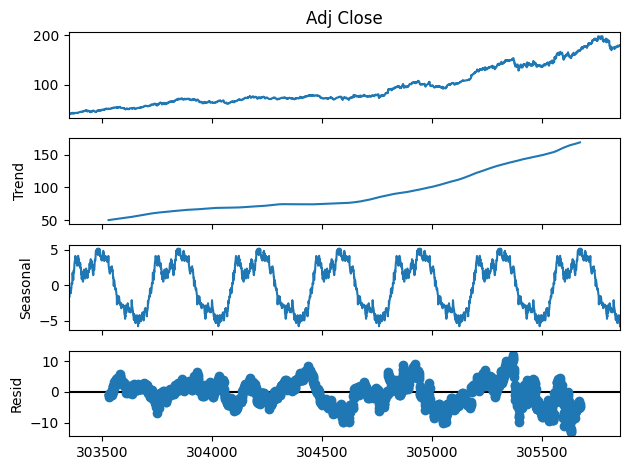


Checking seasonality for PAYX


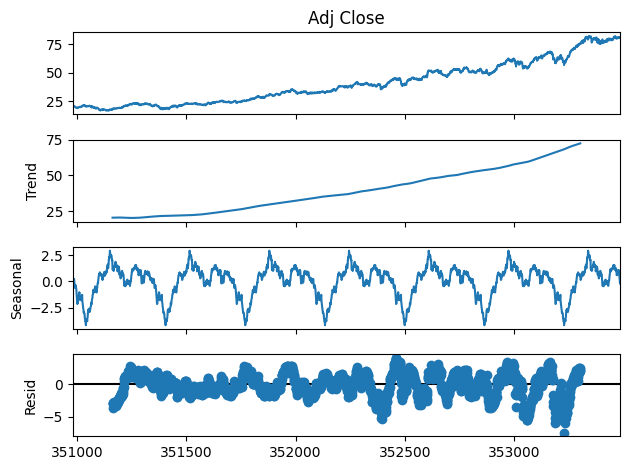


Checking seasonality for RF


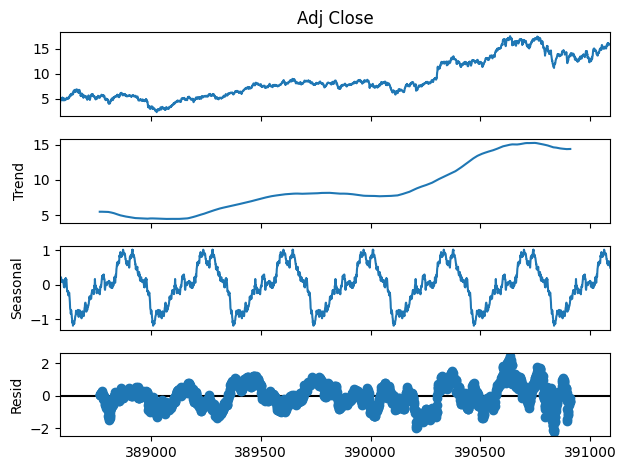


Checking seasonality for SYF


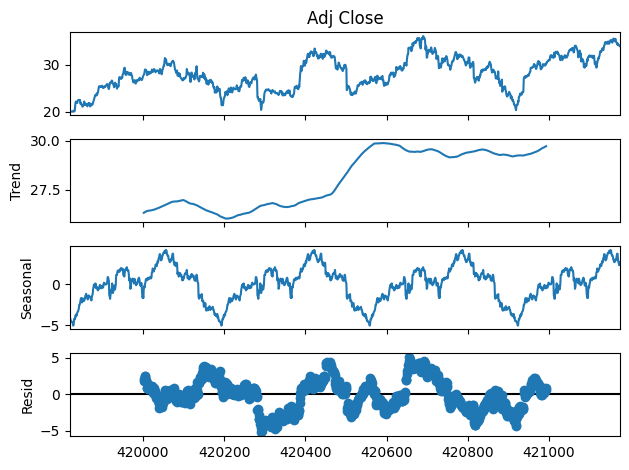


Checking seasonality for TFC


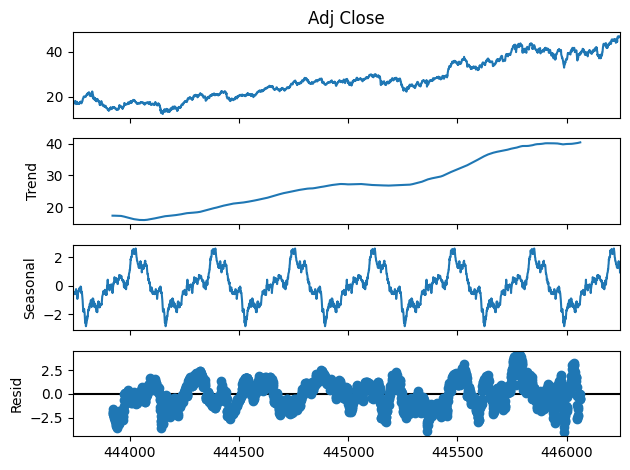


Checking seasonality for ZTS


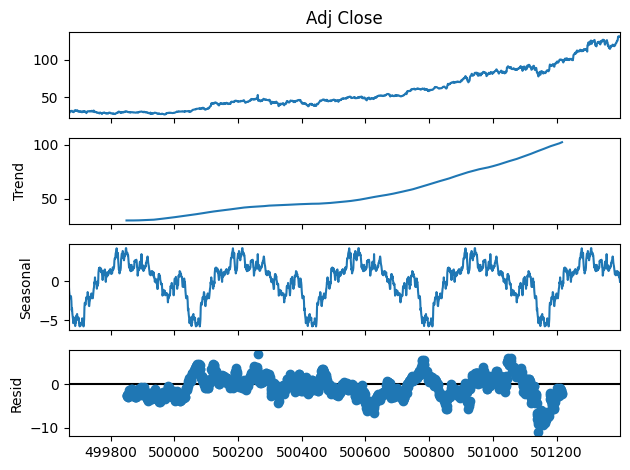

In [8]:
print(potential)

for symbol in potential:
    print(f'\nChecking seasonality for {symbol}')
    plot_seasonality(train_data, symbol)

In [9]:
import matplotlib.dates as mdates

def plot_stock_data(data, symbol, features, start_date=None, end_date=None):
    data = data[data['Symbol'] == symbol]
    data['Date'] = pd.to_datetime(data['Date'])
    if start_date and end_date:
        mask = (data['Date'] >= start_date) & (data['Date'] <= end_date)
        data = data.loc[mask]
    
    plt.figure(figsize=(20, 10))
    for feature in features:
        plt.plot(data['Date'], data[feature], label=feature)
        
    ax = plt.gca()
    
    ax.get_xaxis().set_major_locator(mdates.MonthLocator(interval=2))
    ax.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y-%m'))

    plt.xticks(rotation=45)
    
    plt.legend()
    
    min_date = data.loc[data['Open'].notnull(), 'Date'].min()
    max_date = data.loc[data['Open'].notnull(), 'Date'].max()
    
    date_range = f"{min_date.date()} to {max_date.date()}"
      
    plt.title(f"Stock Data for {symbol} ({date_range})")
    plt.tight_layout()
    plt.show()


My_symbol represents a stock that I will visualize throughout this notebook. I believe it doesn't make much sense to visualize every stock for every exercise, so I chose this one. It has one of the best seasonality strengths, and to me personally, it is a really good example of seasonality.

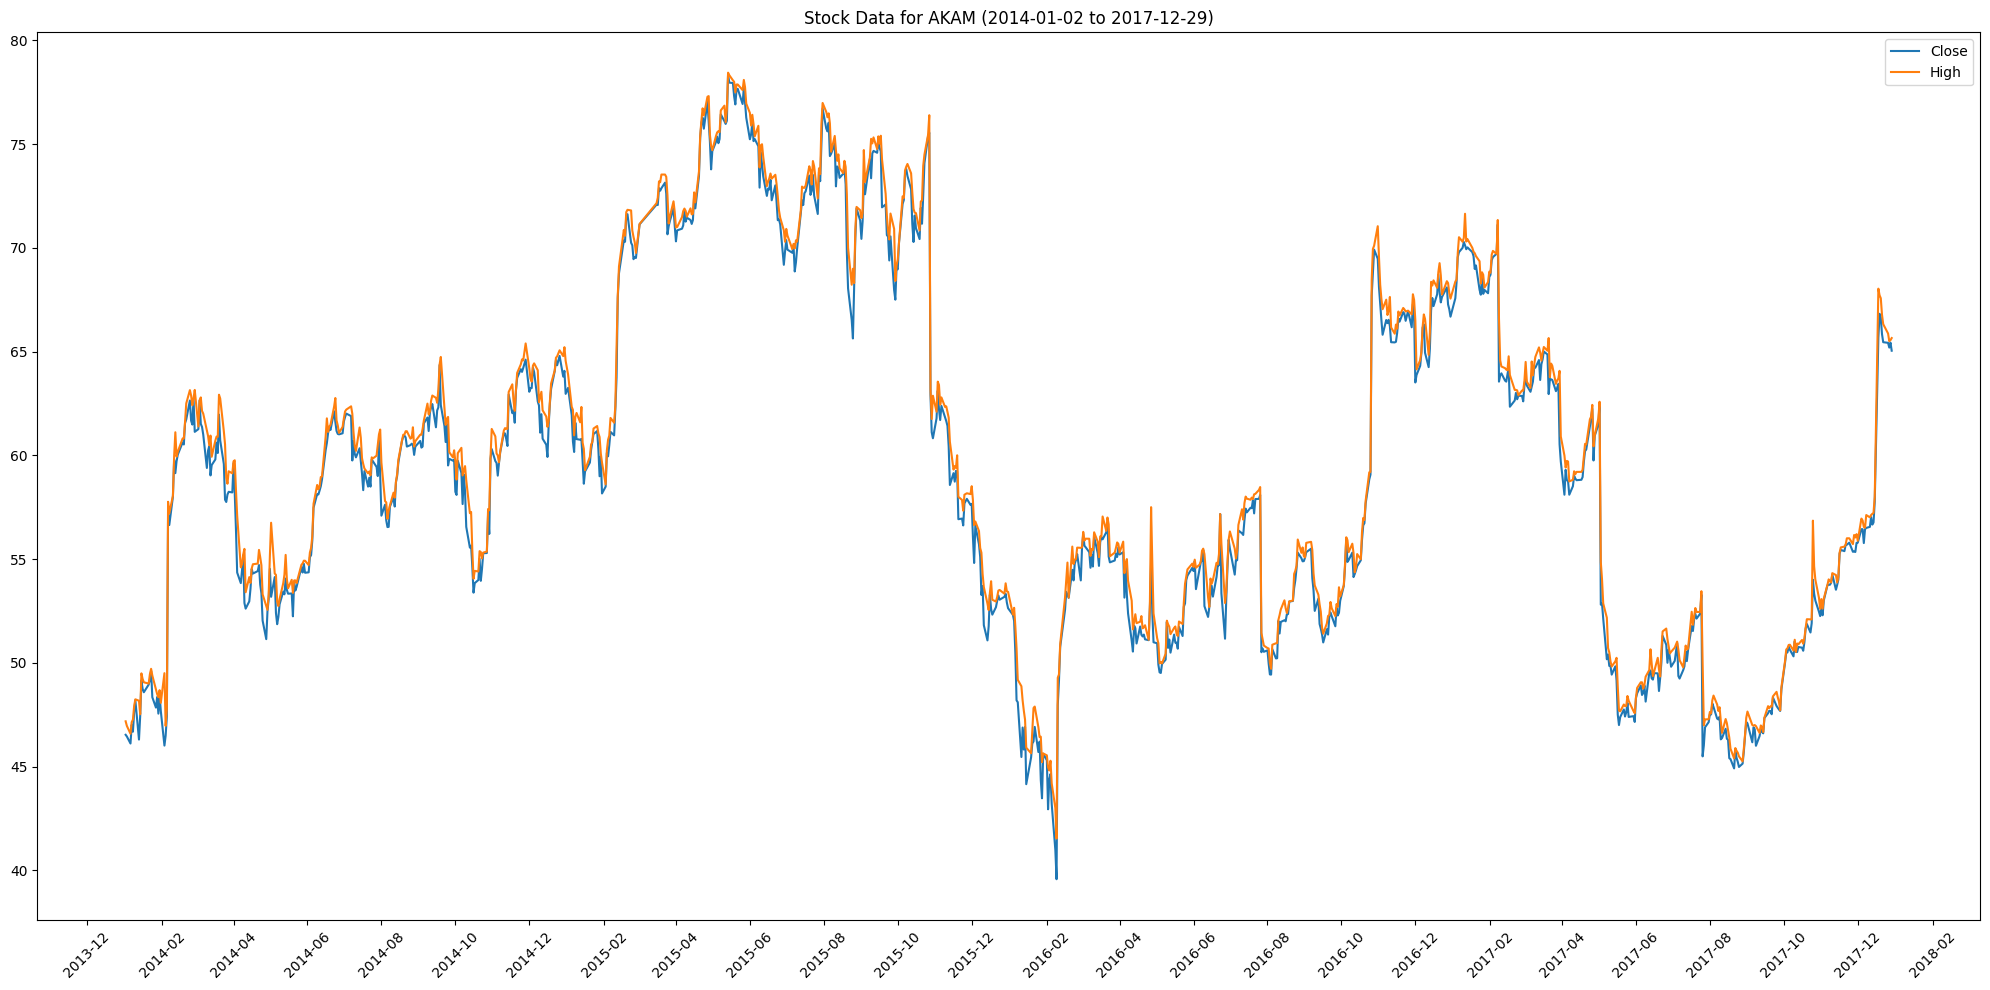

In [10]:
my_symbol = 'AKAM' 
features = ['Close', 'High']

plot_stock_data(train_data, my_symbol, features,
                    start_date='2014-01-01', 
                    end_date='2018-01-01')


# 2. Exponential smoothing
First, I need to extract 70% of the dataset. Then, using the ExponentialSmoothing method, I will try to predict the price movement for the remaining 30%.

In [11]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [12]:
train_set = pd.DataFrame()
test_set = pd.DataFrame()

data = train_data[train_data['Symbol'] == my_symbol]
data['Date'] = pd.to_datetime(data['Date'])

data = data.drop(columns=['Symbol', 'Close', 'High', 'Low', 'Open', 'Volume', 'Target', 'Id'])
train_size = int(len(data) * 0.7)
train_set = pd.concat([train_set, data.iloc[:train_size]])
test_set = pd.concat([test_set, data.iloc[train_size:]])


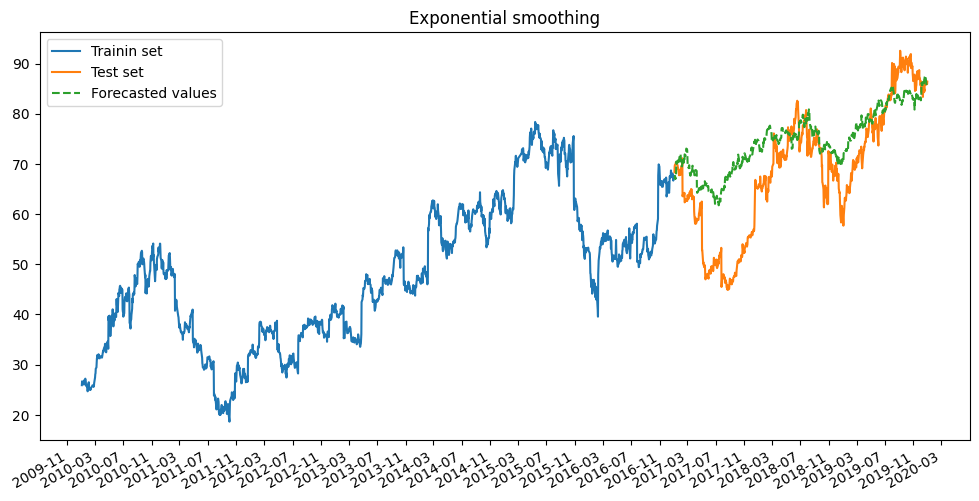

	RMSE: 9.591138690868132
	MAE: 7.462752962403756


In [13]:
from statsmodels.tools.sm_exceptions import ValueWarning
from statsmodels.tools.sm_exceptions import ConvergenceWarning

def smoothing(train_data, test_data):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        warnings.filterwarnings("ignore", category=ValueWarning)
        model = ExponentialSmoothing(train_data['Adj Close'], trend='add', seasonal='add', seasonal_periods=365)
        fit = model.fit()
        forecast = fit.forecast(len(test_data))

        plt.figure(figsize=(12, 6))
        plt.plot(train_data['Date'], train_data['Adj Close'], label='Trainin set')
        plt.plot(test_data['Date'], test_data['Adj Close'], label='Test set')
        plt.plot(test_data['Date'], forecast, label='Forecasted values', linestyle='--')

        plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=4))
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        plt.gcf().autofmt_xdate()

        plt.legend()
        plt.title('Exponential smoothing')
        plt.show()

        rmse = np.sqrt(mean_squared_error(test_data['Adj Close'], forecast))
        mae = mean_absolute_error(test_data['Adj Close'], forecast)

        print(f'\tRMSE: {rmse}')
        print(f'\tMAE: {mae}')
        return rmse, mae

smooth_rmse, smooth_mae = smoothing(train_set, test_set)

Now, I will use the method of trial and error to find the best combination of parameters, i.e., the one that gives the best results, and I will visualize the predictions obtained in this way.

In [14]:
from itertools import product

param_grid = {
    'trend': ['add', 'mul', None],
    'seasonal': ['add', 'mul', None],
    'seasonal_periods': [6, 12, 24, 120, 365]
}

def evaluate_model(train, test, trend, seasonal, seasonal_periods):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        warnings.filterwarnings("ignore", category=ValueWarning)
        model = ExponentialSmoothing(train, trend=trend, seasonal=seasonal, seasonal_periods=seasonal_periods)
        fit = model.fit()
        forecast = fit.forecast(len(test))
        rmse = np.sqrt(mean_squared_error(test, forecast))
        mae = mean_absolute_error(test, forecast)
        return rmse, mae

results = []
for trend, seasonal, seasonal_periods in product(param_grid['trend'], param_grid['seasonal'], param_grid['seasonal_periods']):
    if seasonal is not None and seasonal_periods is None:
        continue
    try:
        rmse, mae = evaluate_model(train_set['Adj Close'], test_set['Adj Close'], trend, seasonal, seasonal_periods)
        results.append((trend, seasonal, seasonal_periods, rmse, mae))
    except:
        continue
        
results_df = pd.DataFrame(results, columns=['Trend', 'Seasonal', 'Seasonal_Periods', 'RMSE', 'MAE'])
print(results_df)


   Trend Seasonal  Seasonal_Periods       RMSE        MAE
0    add      add                 6  11.833109   9.137190
1    add      add                12  11.872908   9.172304
2    add      add                24  11.797291   9.108657
3    add      add               120  12.455589   9.809656
4    add      add               365   9.591139   7.462753
5    add      mul                 6  11.813670   9.120930
6    add      mul                12  11.875539   9.174856
7    add      mul                24  11.804238   9.110700
8    add      mul               120  12.310481   9.668149
9    add      mul               365   8.556574   6.563122
10   add     None                 6  11.805560   9.115007
11   add     None                12  11.805560   9.115007
12   add     None                24  11.805560   9.115007
13   add     None               120  11.805560   9.115007
14   add     None               365  11.805560   9.115007
15   mul      add                 6  10.964221   8.570876
16   mul      

Best parameters: Trend                    mul
Seasonal                 mul
Seasonal_Periods         365
RMSE                8.492809
MAE                 6.527861
Name: 24, dtype: object


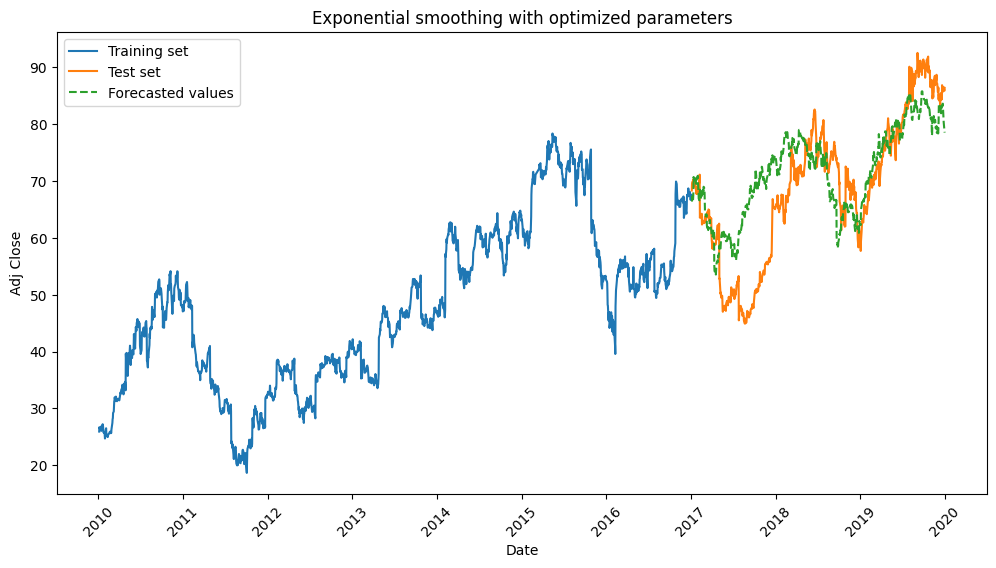

Best RMSE: 8.492808660050343
Best MAE: 6.527861273875094


In [15]:
best_params = results_df.loc[results_df['RMSE'].idxmin()]
print('Best parameters:', best_params)

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    warnings.filterwarnings("ignore", category=ValueWarning)
    best_model = ExponentialSmoothing(
        train_set['Adj Close'],
        trend=best_params['Trend'],
        seasonal=best_params['Seasonal'],
        seasonal_periods=best_params['Seasonal_Periods']
    )
    best_fit = best_model.fit()
    best_forecast = best_fit.forecast(len(test_set))

plt.figure(figsize=(12, 6))
plt.plot(train_set['Date'], train_set['Adj Close'], label='Training set')
plt.plot(test_set['Date'], test_set['Adj Close'], label='Test set')
plt.plot(test_set['Date'], best_forecast, label='Forecasted values', linestyle='--')
plt.legend()
plt.title('Exponential smoothing with optimized parameters')
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.xticks(rotation=45)
plt.show()

optimized_smoothing_rmse = np.sqrt(mean_squared_error(test_set['Adj Close'], best_forecast))
optimized_smoothing_mae = mean_absolute_error(test_set['Adj Close'], best_forecast)

print(f'Best RMSE: {optimized_smoothing_rmse}')
print(f'Best MAE: {optimized_smoothing_mae}')

# 3. ARIMA
My initial attempt will demonstrate how the ARIMA model behaves with parameters (0, 0, 0).

RMSE: 24.81070522907093
MAE: 21.53505006699699


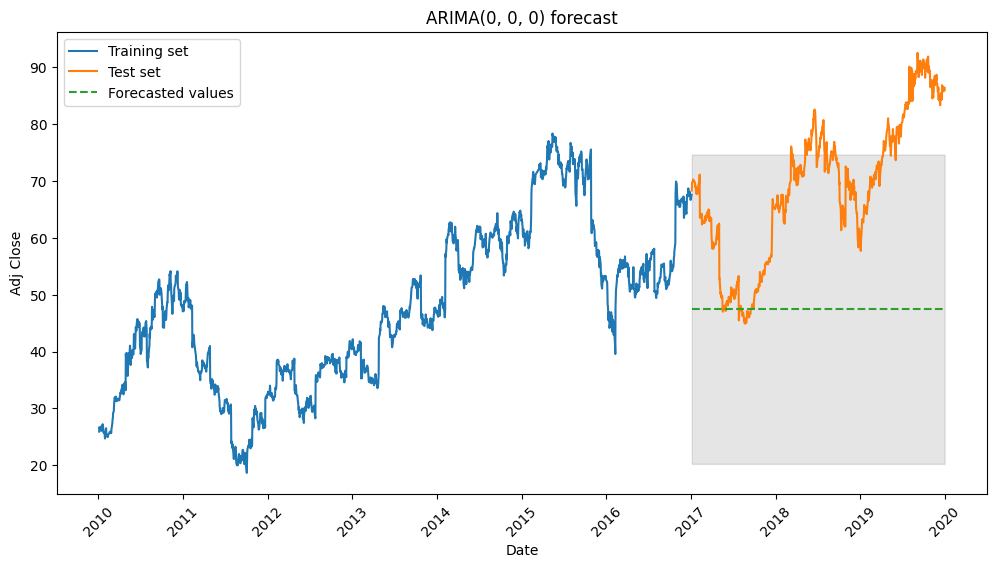

In [16]:
from statsmodels.tsa.arima.model import ARIMA

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    warnings.filterwarnings("ignore", category=ValueWarning)
    model = ARIMA(train_set['Adj Close'], order=(0, 0, 0))
    fit = model.fit()

    forecast = fit.forecast(steps=len(test_set))
    forecast_conf_int = fit.get_forecast(steps=len(test_set)).conf_int()

arima_000_rmse = np.sqrt(mean_squared_error(test_set['Adj Close'], forecast))
arima_000_mae = mean_absolute_error(test_set['Adj Close'], forecast)

print(f'RMSE: {arima_000_rmse}')
print(f'MAE: {arima_000_mae}')

plt.figure(figsize=(12, 6))
plt.plot(train_set['Date'], train_set['Adj Close'], label='Training set')
plt.plot(test_set['Date'], test_set['Adj Close'], label='Test set')
plt.plot(test_set['Date'], forecast, label='Forecasted values', linestyle='--')
plt.fill_between(test_set["Date"], forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='k', alpha=0.1)
plt.legend()
plt.title('ARIMA(0, 0, 0) forecast')
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.xticks(rotation=45)
plt.show()


Now we will try to optimize the parameter `p` of the ARIMA model. We will test values from 1 to 5.

Best p: 5 with RMSE: 20.41906225876199


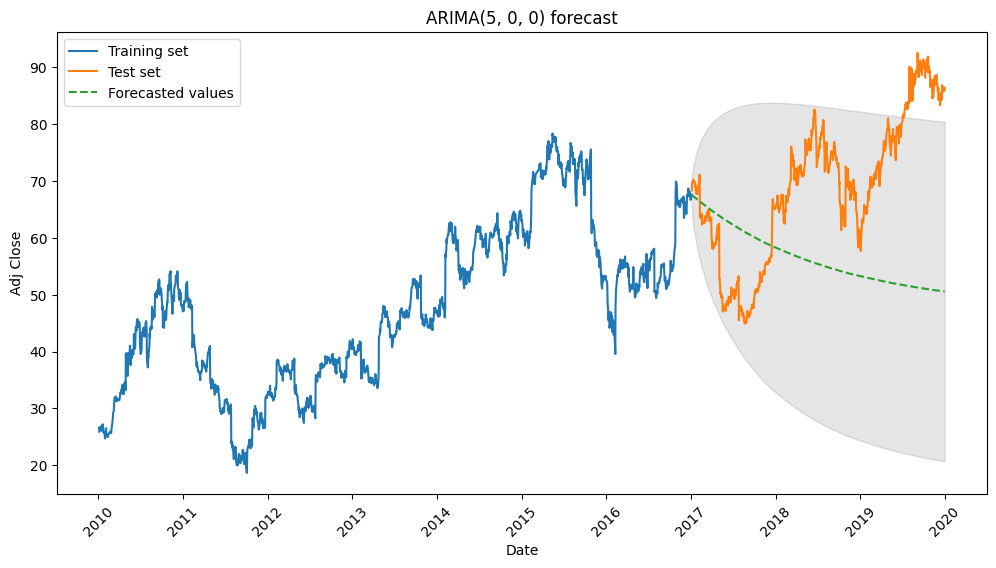

In [17]:
p_values = [1, 2, 3, 4, 5]
best_p = 0
arima_p00_rmse = float('inf')
arima_p00_mae = float('inf')


for p in p_values:
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        warnings.filterwarnings("ignore", category=ValueWarning)
        model = ARIMA(train_set['Adj Close'], order=(p, 0, 0))
        fit = model.fit()
        forecast = fit.forecast(steps=len(test_set))
        rmse = np.sqrt(mean_squared_error(test_set['Adj Close'], forecast))
        if rmse < arima_p00_rmse:
            arima_p00_rmse = rmse
            arima_p00_mae = mean_absolute_error(test_set['Adj Close'], forecast)
            best_p = p

print(f'Best p: {best_p} with RMSE: {arima_p00_rmse}')

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    warnings.filterwarnings("ignore", category=ValueWarning)
    model = ARIMA(train_set['Adj Close'], order=(best_p, 0, 0))
    fit = model.fit()
    forecast = fit.forecast(steps=len(test_set))
    forecast_conf_int = fit.get_forecast(steps=len(test_set)).conf_int()

plt.figure(figsize=(12, 6))
plt.plot(train_set['Date'], train_set['Adj Close'], label='Training set')
plt.plot(test_set['Date'], test_set['Adj Close'], label='Test set')
plt.plot(test_set['Date'], forecast, label='Forecasted values', linestyle='--')
plt.fill_between(test_set["Date"], forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='k', alpha=0.1)
plt.legend()
plt.title(f'ARIMA({best_p}, 0, 0) forecast')
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.xticks(rotation=45)
plt.show()


Now we will try to optimize the parameter `q` of the ARIMA model. We will test values from 1 to 5.

Best q is 5 with RMSE = 24.766739053861915


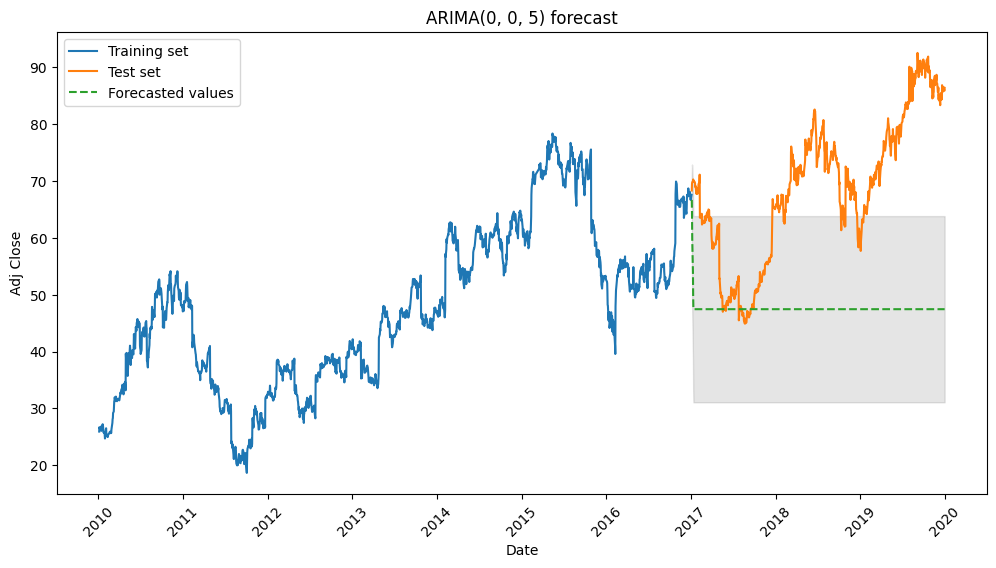

In [18]:
q_values = [1, 2, 3, 4, 5]
best_q = 0
arima_00q_rmse = float('inf')
arima_00q_mae = float('inf')

for q in q_values:
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        warnings.filterwarnings("ignore", category=ValueWarning)
        model = ARIMA(train_set['Adj Close'], order=(0, 0, q))
        fit = model.fit()
        forecast = fit.forecast(steps=len(test_set))
        rmse = np.sqrt(mean_squared_error(test_set['Adj Close'], forecast))
        if rmse < arima_00q_rmse:
            arima_00q_rmse = rmse
            arima_00q_mae = mean_absolute_error(test_set['Adj Close'], forecast)
            best_q = q
    
print(f'Best q is {best_q} with RMSE = {arima_00q_rmse}')

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    warnings.filterwarnings("ignore", category=ValueWarning)
    model = ARIMA(train_set['Adj Close'], order=(0, 0, best_q))
    fit = model.fit()
    forecast = fit.forecast(steps=len(test_set))
    forecast_conf_int = fit.get_forecast(steps=len(test_set)).conf_int()

plt.figure(figsize=(12, 6))
plt.plot(train_set['Date'], train_set['Adj Close'], label='Training set')
plt.plot(test_set['Date'], test_set['Adj Close'], label='Test set')
plt.plot(test_set['Date'], forecast, label='Forecasted values', linestyle='--')
plt.fill_between(test_set["Date"], forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='k', alpha=0.1)
plt.legend()
plt.title(f'ARIMA(0, 0, {best_q}) forecast')
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.xticks(rotation=45)
plt.show()

Now we will try to optimize the parameter `d` of the ARIMA model. We will test values from 0 to 2.

Best d is 1 with RMSE = 12.568261086223965


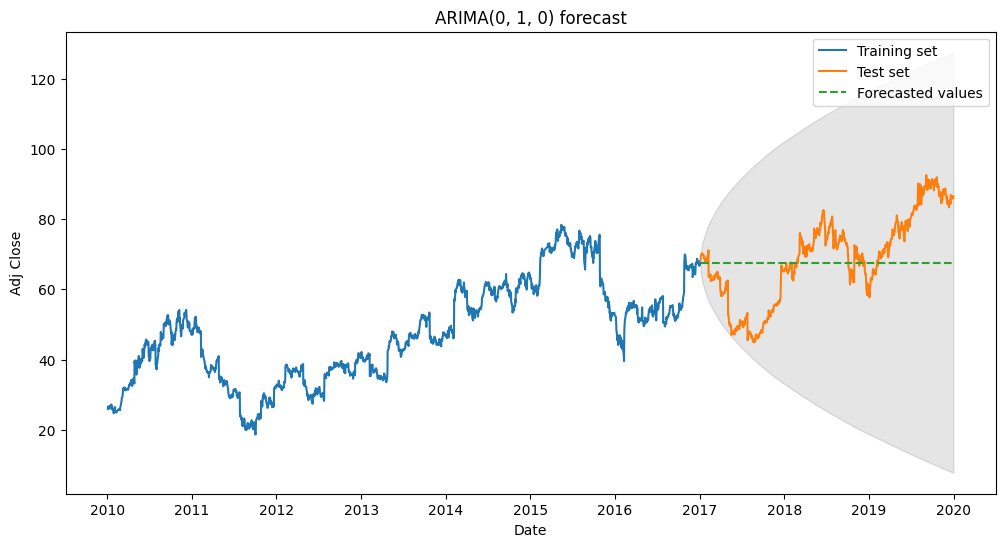

In [19]:
d_values = [0, 1, 2]
best_d = 0
arima_0d0_rmse = float('inf')
arima_0d0_mae = float('inf')

for d in d_values:
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        warnings.filterwarnings("ignore", category=ValueWarning)
        model = ARIMA(train_set['Adj Close'], order=(0, d, 0))
        fit = model.fit()
        forecast = fit.forecast(steps=len(test_set))
        rmse = np.sqrt(mean_squared_error(test_set['Adj Close'], forecast))
        if rmse < arima_0d0_rmse:
            arima_0d0_rmse = rmse
            arima_0d0_mae = mean_absolute_error(test_set['Adj Close'], forecast)
            best_d = d

print(f'Best d is {best_d} with RMSE = {arima_0d0_rmse}')

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    warnings.filterwarnings("ignore", category=ValueWarning)
    model = ARIMA(train_set['Adj Close'], order=(0, best_d, 0))
    fit = model.fit()
    forecast = fit.forecast(steps=len(test_set))
    forecast_conf_int = fit.get_forecast(steps=len(test_set)).conf_int()

plt.figure(figsize=(12, 6))
plt.plot(train_set['Date'], train_set['Adj Close'], label='Training set')
plt.plot(test_set['Date'], test_set['Adj Close'], label='Test set')
plt.plot(test_set['Date'], forecast, label='Forecasted values', linestyle='--')
plt.fill_between(test_set["Date"], forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='k', alpha=0.1)
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.legend()
plt.title(f'ARIMA(0, {best_d}, 0) forecast')
plt.show()


Now we will try to find the best combination od factors `p`, `q` and `d`.

Best parameters are (1, 2, 3) with RMSE = 11.802471553635689


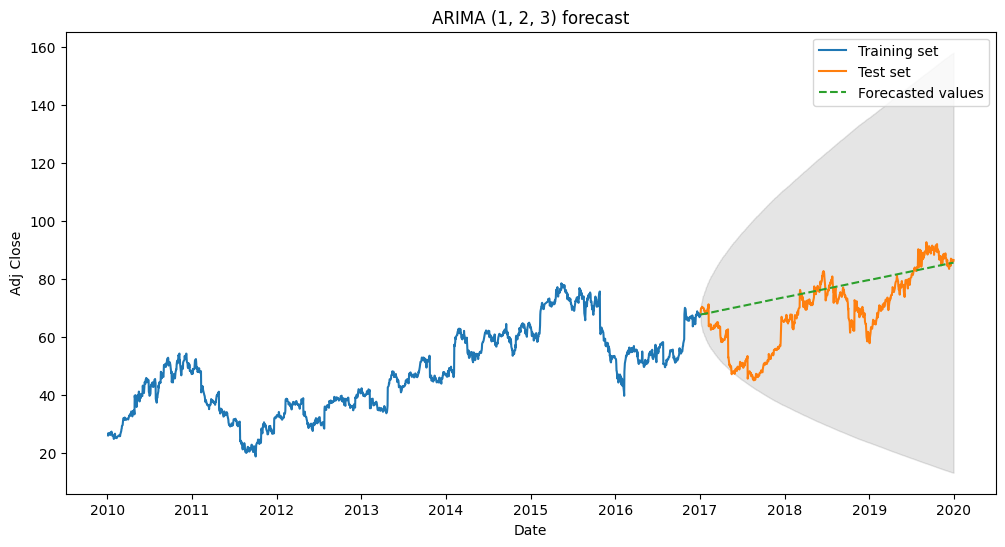

In [20]:
import itertools

p_values = [1, 3, 5]
d_values = [0, 1, 2]
q_values = [1, 3, 5]
best_pdq = (0, 0, 0)
arima_pdq_rmse = float('inf')
arima_pdq_mae = float('inf')

for pdq in itertools.product(p_values, d_values, q_values):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        warnings.filterwarnings("ignore", category=ValueWarning)
        model = ARIMA(train_set['Adj Close'], order=pdq)
        fit = model.fit()
        forecast = fit.forecast(steps=len(test_set))
        rmse = np.sqrt(mean_squared_error(test_set['Adj Close'], forecast))
        if rmse < arima_pdq_rmse:
            arima_pdq_rmse = rmse
            arima_pdq_mae = mean_absolute_error(test_set['Adj Close'], forecast)
            best_pdq = pdq

print(f'Best parameters are {best_pdq} with RMSE = {arima_pdq_rmse}')

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    warnings.filterwarnings("ignore", category=ValueWarning)
    model = ARIMA(train_set['Adj Close'], order=best_pdq)
    fit = model.fit()
    forecast = fit.forecast(steps=len(test_set))
    forecast_conf_int = fit.get_forecast(steps=len(test_set)).conf_int()

plt.figure(figsize=(12, 6))
plt.plot(train_set['Date'], train_set['Adj Close'], label='Training set')
plt.plot(test_set['Date'], test_set['Adj Close'], label='Test set')
plt.plot(test_set['Date'], forecast, label='Forecasted values', linestyle='--')
plt.fill_between(test_set["Date"], forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='k', alpha=0.1)
plt.legend()
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.title(f'ARIMA {best_pdq} forecast')
plt.show()


What remains is to try to optimize the seasonality, which I will attempt by using the `SARIMAX` function with different values of `s`.

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.54892D+00    |proj g|=  5.39058D-02


 This problem is unconstrained.



At iterate    5    f=  1.52830D+00    |proj g|=  1.87839D-02

At iterate   10    f=  1.52449D+00    |proj g|=  1.73908D-03

At iterate   15    f=  1.52417D+00    |proj g|=  1.62965D-03

At iterate   20    f=  1.52411D+00    |proj g|=  1.31461D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     24     30      1     0     0   1.407D-05   1.524D+00
  F =   1.5241067548765443     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  1.52801D+00    |proj g|=  1.63013D-02

At iterate   10    f=  1.52481D+00    |proj g|=  1.92328D-03

At iterate   15    f=  1.52439D+00    |proj g|=  1.63744D-03

At iterate   20    f=  1.52424D+00    |proj g|=  4.67629D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     24     28      1     0     0   1.749D-05   1.524D+00
  F =   1.5242150540727257     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  1.52846D+00    |proj g|=  3.11485D-02

At iterate   10    f=  1.52460D+00    |proj g|=  1.17561D-03

At iterate   15    f=  1.52426D+00    |proj g|=  8.28638D-04

At iterate   20    f=  1.52422D+00    |proj g|=  3.14984D-03

At iterate   25    f=  1.52421D+00    |proj g|=  1.05740D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     30      1     0     0   4.168D-07   1.524D+00
  F =   1.5242094393938435     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Najbolji s: 6 s RMSE: 11.80093687920249
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-1

 This problem is unconstrained.



At iterate    5    f=  1.52830D+00    |proj g|=  1.87839D-02

At iterate   10    f=  1.52449D+00    |proj g|=  1.73908D-03

At iterate   15    f=  1.52417D+00    |proj g|=  1.62965D-03

At iterate   20    f=  1.52411D+00    |proj g|=  1.31461D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     24     30      1     0     0   1.407D-05   1.524D+00
  F =   1.5241067548765443     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


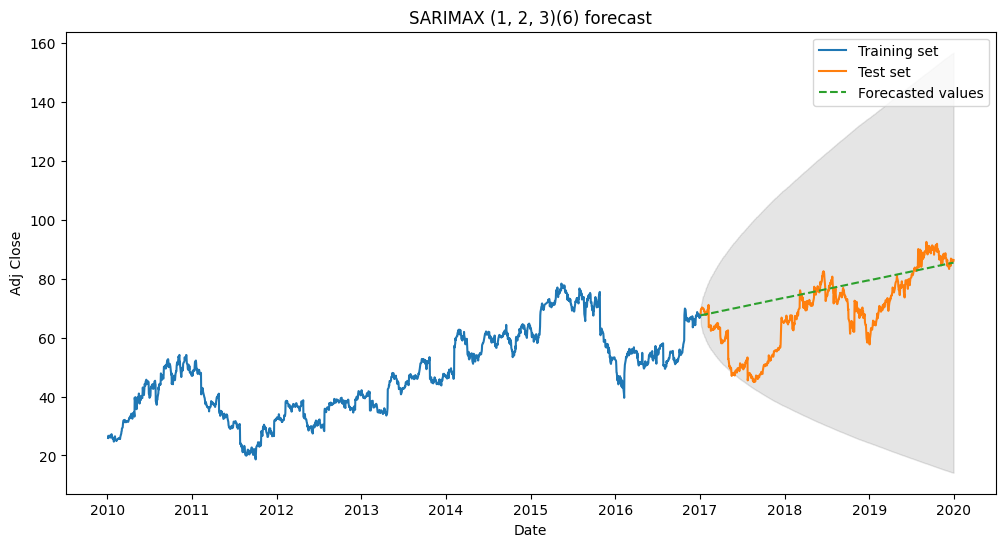

In [21]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

s_values = [6, 12, 24]
best_s = 0
sarimax_rmse = float('inf')
sarimax_mae = float('inf')

for s in s_values:
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        warnings.filterwarnings("ignore", category=ValueWarning)
        model = SARIMAX(train_set['Adj Close'], order=best_pdq, seasonal_order=(1, 0, 0, s))
        fit = model.fit()
        forecast = fit.forecast(steps=len(test_set))
        rmse = np.sqrt(mean_squared_error(test_set['Adj Close'], forecast))
        if rmse < sarimax_rmse:
            sarimax_rmse = rmse
            sarimax_mae = mean_absolute_error(test_set['Adj Close'], forecast)
            best_s = s

print(f'Najbolji s: {best_s} s RMSE: {sarimax_rmse}')

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    warnings.filterwarnings("ignore", category=ValueWarning)
    model = SARIMAX(train_set['Adj Close'], order=best_pdq, seasonal_order=(1, 0, 0, best_s))
    fit = model.fit()
    forecast = fit.forecast(steps=len(test_set))
    forecast_conf_int = fit.get_forecast(steps=len(test_set)).conf_int()

plt.figure(figsize=(12, 6))
plt.plot(train_set['Date'], train_set['Adj Close'], label='Training set')
plt.plot(test_set['Date'], test_set['Adj Close'], label='Test set')
plt.plot(test_set['Date'], forecast, label='Forecasted values', linestyle='--')
plt.fill_between(test_set["Date"], forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='k', alpha=0.1)
plt.legend()
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.title(f'SARIMAX {best_pdq}({best_s}) forecast')
plt.show()


# 4. Facebook Prophet

10:20:37 - cmdstanpy - INFO - Chain [1] start processing
10:20:37 - cmdstanpy - INFO - Chain [1] done processing



Prophet RMSE: 33.61277984233646
Prophet MAE: 28.540482233517675



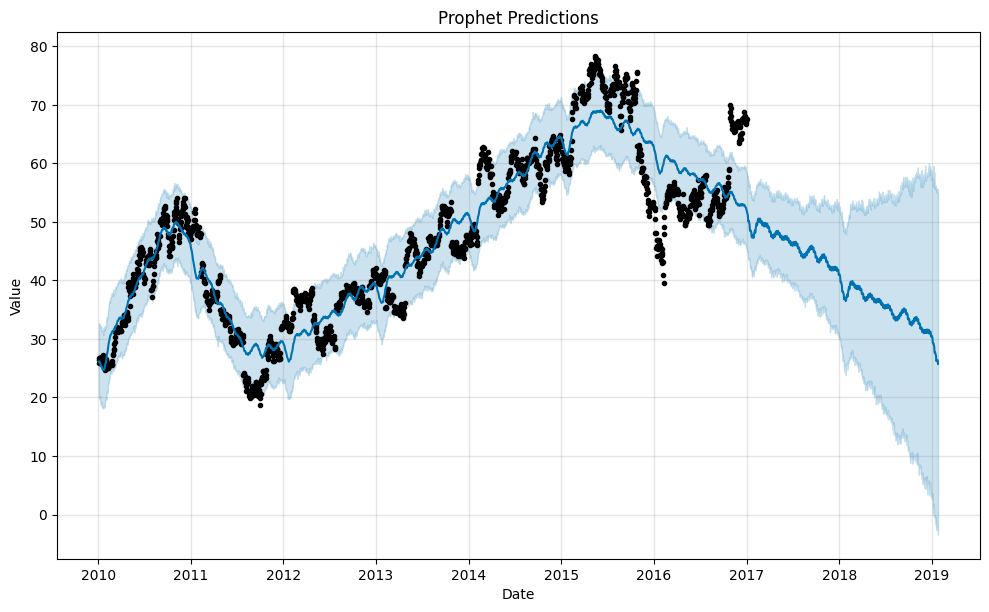

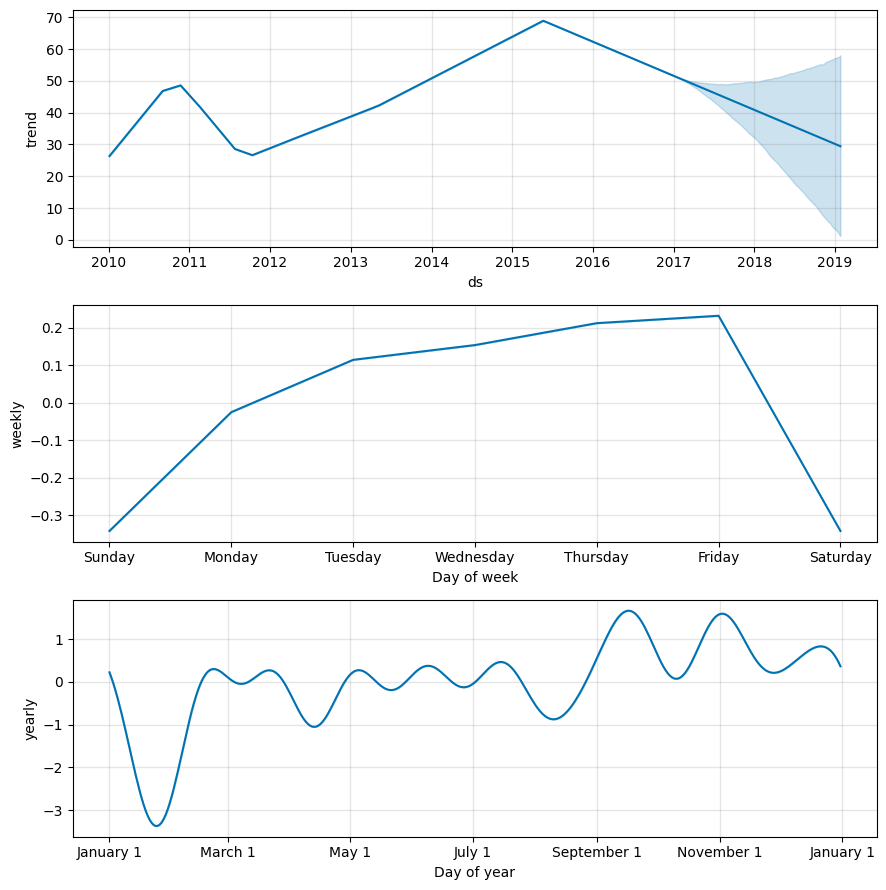

In [38]:
from prophet import Prophet

data2 = train_data[train_data['Symbol'] == my_symbol]
data2['ds'] = pd.to_datetime(data2['Date'])
data2.rename(columns={'Adj Close': 'y'}, inplace=True)

train_size = int(len(data2) * 0.7)
train2, test2 = data2.iloc[:train_size], data2.iloc[train_size:]

model = Prophet()
model.fit(train2)
future = model.make_future_dataframe(periods=len(test2))
forecast = model.predict(future)

fb_rmse = np.sqrt(mean_squared_error(test2['y'], forecast['yhat'][-len(test2):]))
fb_mae = mean_absolute_error(test2['y'], forecast['yhat'][-len(test2):])

print(f'\nProphet RMSE: {fb_rmse}')
print(f'Prophet MAE: {fb_mae}\n')

fig = model.plot(forecast)
plt.title('Prophet Predictions')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

fig_comp = model.plot_components(forecast)
plt.show()


Now, I will add significant stock market dates, such as dates of major crashes, to Facebook Prophet. Additionally, I will include U.S. holidays and see if these adjustments yield better results.

10:23:42 - cmdstanpy - INFO - Chain [1] start processing
10:23:42 - cmdstanpy - INFO - Chain [1] done processing



RMSE with holidays: 33.480954705761576
MAE with holidays: 28.42440950844702



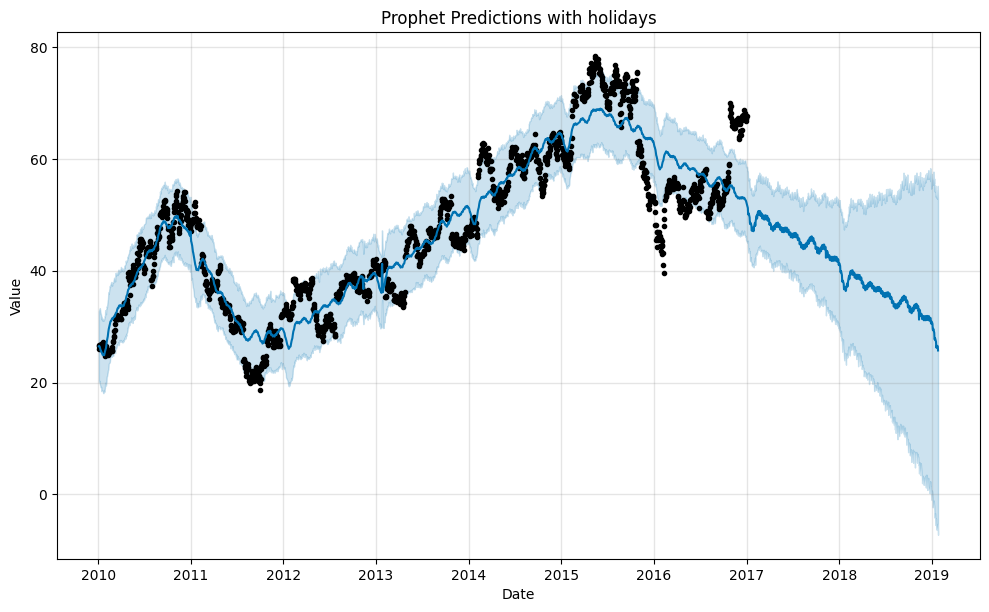

In [42]:
holidays = pd.DataFrame({
  'holiday': 'stock_market_crash',
  'ds': pd.to_datetime(['1987-10-19', '2000-09-29', '2008-09-29', '2013-01-24', '2020-03-09']),
  'lower_window': 0,
  'upper_window': 1,
})

model1 = Prophet(holidays=holidays)

model1.add_country_holidays('US')

model1.fit(train2)
forecast_holidays = model1.predict(future)

rmse_holidays = np.sqrt(mean_squared_error(test2['y'], forecast_holidays['yhat'][-len(test2):]))
mae_holidays = mean_absolute_error(test2['y'], forecast_holidays['yhat'][-len(test2):])

print(f'\nRMSE with holidays: {rmse_holidays}')
print(f'MAE with holidays: {mae_holidays}\n')

fig_holidays = model1.plot(forecast_holidays)
plt.title('Prophet Predictions with holidays')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()


# 5. RandomForestRegressor

In [24]:
from sklearn.ensemble import RandomForestRegressor

	RMSE: 4.41919899311389
	MAE: 2.4929791031999793


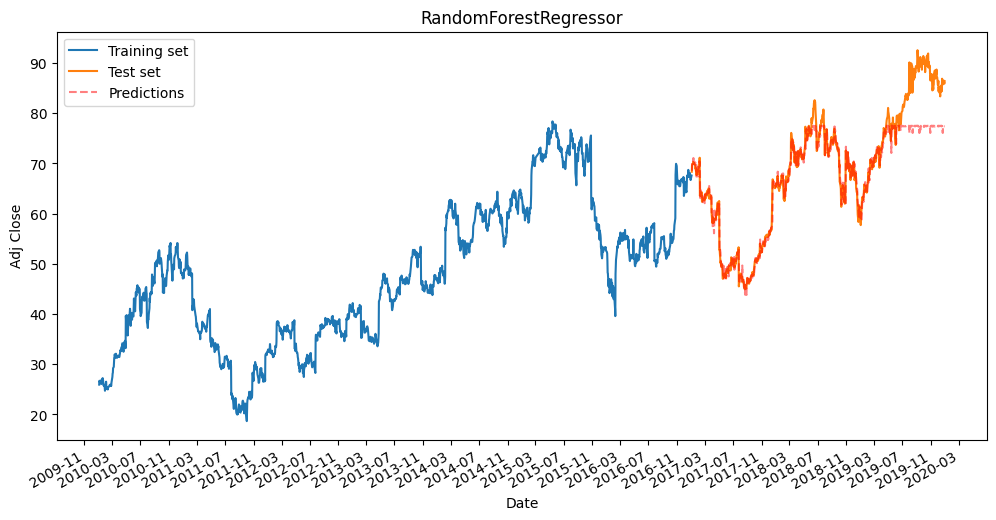

In [25]:
def random_forest_prediction(data):
    
    features = ['Target', 'Close', 'High', 'Low', 'Open', 'Volume']
    target = 'Adj Close'
    
    X = data[features].iloc[:-1]
    y = data[target].iloc[1:]
    
    train_size = int(len(X) * 0.7)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    
    print(f'\tRMSE: {rmse}')
    print(f'\tMAE: {mae}')

    plt.figure(figsize=(12, 6))
    plt.plot(data.index[:train_size], data[target][:train_size], label='Training set')
    plt.plot(data.index[train_size:], data[target][train_size:], label='Test set')
    plt.plot(data.index[train_size+1:], y_pred, label='Predictions', linestyle='--', color="red", alpha=0.5)

    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=4))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.gcf().autofmt_xdate()
    
    plt.legend()
    plt.title(f'RandomForestRegressor')
    plt.xlabel('Date')
    plt.ylabel('Adj Close')
    plt.show()
    
    return rmse, mae

data3 = train_data[train_data['Symbol'] == my_symbol]
data3['Date'] = pd.to_datetime(data3['Date'])
data3.set_index('Date', inplace=True)

rf_rmse, rf_mae = random_forest_prediction(data3)

### Final results
This is the display of `RMSE` and `MAE` results for all `ARIMA` models with parameter optimization, `Facebook Prophet` with and without holidays and `Random Forest` model.

In [26]:
results_arima = pd.DataFrame({
    'Model': ['ARIMA(0,0,0)', f'ARIMA({best_p},0,0)', f'ARIMA(0,0,{best_q})', f'ARIMA(0,{best_d},0)', f'ARIMA{best_pdq}', f'SARIMAX{best_pdq}({best_s})'],
    'RMSE': [arima_000_rmse, arima_p00_rmse, arima_00q_rmse, arima_0d0_rmse, arima_pdq_rmse, sarimax_rmse],
    'MAE': [arima_000_mae, arima_p00_mae, arima_00q_mae, arima_0d0_mae, arima_pdq_mae, sarimax_mae]
})
results_prophet = pd.DataFrame({
    'Model': ['Prophet', 'Prophet with holidays'],
    'RMSE': [fb_rmse, rmse_holidays],
    'MAE': [fb_mae, mae_holidays]
})
results_random_forest = pd.DataFrame({
    'Model': ['Random Forest'],
    'RMSE': [rf_rmse],
    'MAE': [rf_mae]
})

results = pd.concat([results_arima, results_prophet, results_random_forest], ignore_index=True)
results

,Model,RMSE,MAE
0,"ARIMA(0,0,0)",24.810705,21.535050
1,"ARIMA(5,0,0)",20.419062,17.357303
2,"ARIMA(0,0,5)",24.766739,21.459298
3,"ARIMA(0,1,0)",12.568261,10.314648
4,"ARIMA(1, 2, 3)",11.802472,9.112555
5,"SARIMAX(1, 2, 3)(6)",11.800937,9.111251
6,Prophet,33.612780,28.540482
7,Prophet with holidays,33.666760,28.603442
8,Random Forest,4.419199,2.492979


# 6. Generated signal

In [27]:
from scipy import signal
t = np.linspace(0, 600, 600)
triangle1 = signal.sawtooth(2 * np.pi * 2 * 100 * t) 
triangle2 = signal.sawtooth(2 * np.pi * 2 * 28.57142857 * t, 0.63) 
trend = np.linspace(0, 600, 600)/(165*np.pi)
trend1 = np.linspace(0, 100, 100)/(112*np.pi)
trend2 = np.linspace(0, 300, 300)/(-103*np.pi)
trend3 = np.linspace(0, 200, 200)/(148*np.pi/2)
noise = np.random.normal(0,0.1056,600)
pts = triangle1 + triangle2 + trend + np.concatenate((trend1, trend2, trend3)) + noise

# constants
last_n_rows = 600
n_train_rows = 500

# split
pts_train = pts[:-(last_n_rows-n_train_rows)]
pts_test = pts[-(last_n_rows-n_train_rows):]

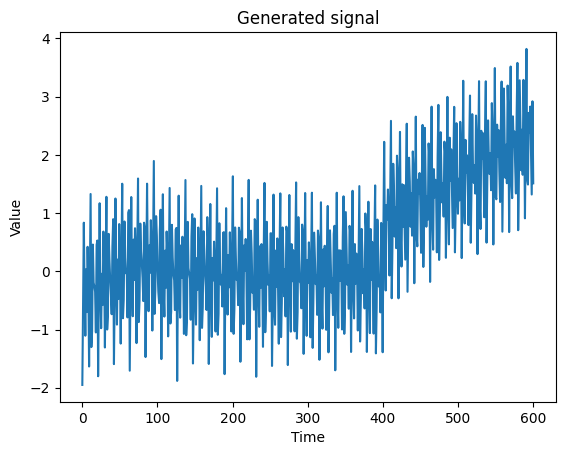

In [28]:
plt.plot(t, pts)
plt.title('Generated signal')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

Here I will try to make predictions of the generated signal using `ExponentialSmoothing`.

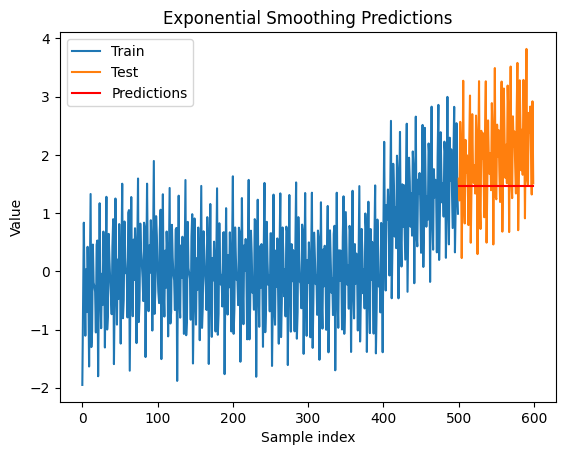

In [29]:
model = ExponentialSmoothing(pts_train)
fitted_model = model.fit()

predictions = fitted_model.forecast(len(pts_test))

plt.plot(pts_train, label='Train')
plt.plot(range(len(pts_train), len(pts)), pts_test, label='Test')
plt.plot(range(len(pts_train), len(pts)), predictions, label='Predictions', color = 'red')
plt.title('Exponential Smoothing Predictions')
plt.xlabel('Sample index')
plt.ylabel('Value')
plt.legend()
plt.show()

Here I will try to make predictions of the generated signal using `ARIMA`.

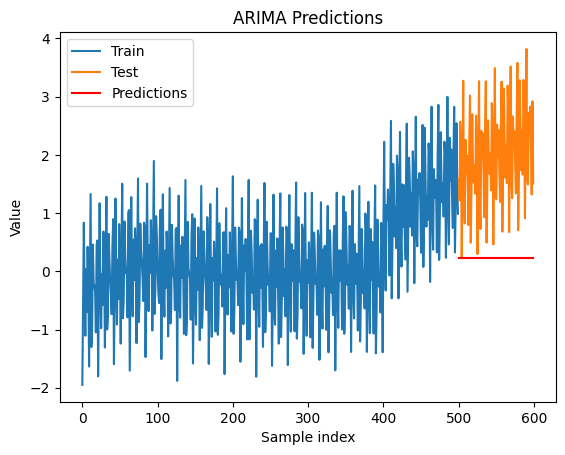

In [30]:
model = ARIMA(pts_train, order=(0, 0, 0))
fitted_model = model.fit()

predictions = fitted_model.forecast(steps=len(pts_test))

plt.plot(pts_train, label='Train')
plt.plot(range(len(pts_train), len(pts)), pts_test, label='Test')
plt.plot(range(len(pts_train), len(pts)), predictions, label='Predictions', color = 'red')
plt.title('ARIMA Predictions')
plt.xlabel('Sample index')
plt.ylabel('Value')
plt.legend()
plt.show()

I will now try `ARIMA` again, but this time with parameter optimization.

Best parameters are (5, 2, 3) with RMSE = 0.3857845359328738


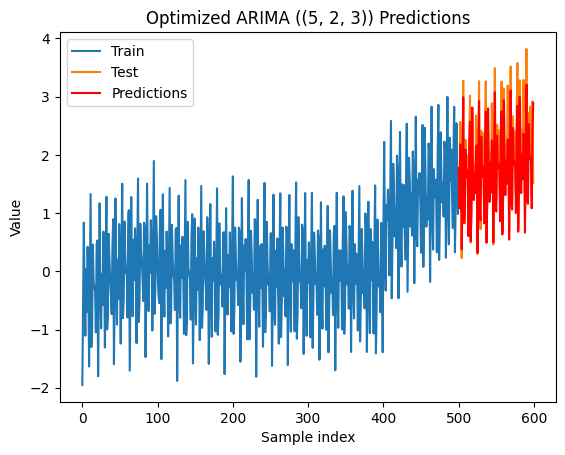

In [31]:
signal_pdq_rmse = float('inf')
signal_pdq_mae = float('inf')

for signal_pdq in itertools.product(p_values, d_values, q_values):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        warnings.filterwarnings("ignore", category=ValueWarning)
        model = ARIMA(pts_train, order=signal_pdq)
        fit = model.fit()
        forecast = fit.forecast(steps=len(pts_test))
        rmse = np.sqrt(mean_squared_error(pts_test, forecast))
        if rmse < signal_pdq_rmse:
            signal_pdq_rmse = rmse
            signal_pdq_mae = mean_absolute_error(pts_test, forecast)
            signal_best_pdq = signal_pdq

print(f'Best parameters are {signal_best_pdq} with RMSE = {signal_pdq_rmse}')

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    warnings.filterwarnings("ignore", category=ValueWarning)
    model = ARIMA(pts_train, order=signal_best_pdq)
    fitted_model = model.fit()
    predictions = fitted_model.forecast(steps=len(pts_test))

plt.plot(pts_train, label='Train')
plt.plot(range(len(pts_train), len(pts)), pts_test, label='Test')
plt.plot(range(len(pts_train), len(pts)), predictions, label='Predictions', color = 'red')
plt.title(f'Optimized ARIMA ({signal_best_pdq}) Predictions')
plt.xlabel('Sample index')
plt.ylabel('Value')
plt.legend()
plt.show()

Here I will try to make predictions of the generated signal using `Facebook Prohphet`.

10:15:30 - cmdstanpy - INFO - Chain [1] start processing
10:15:30 - cmdstanpy - INFO - Chain [1] done processing


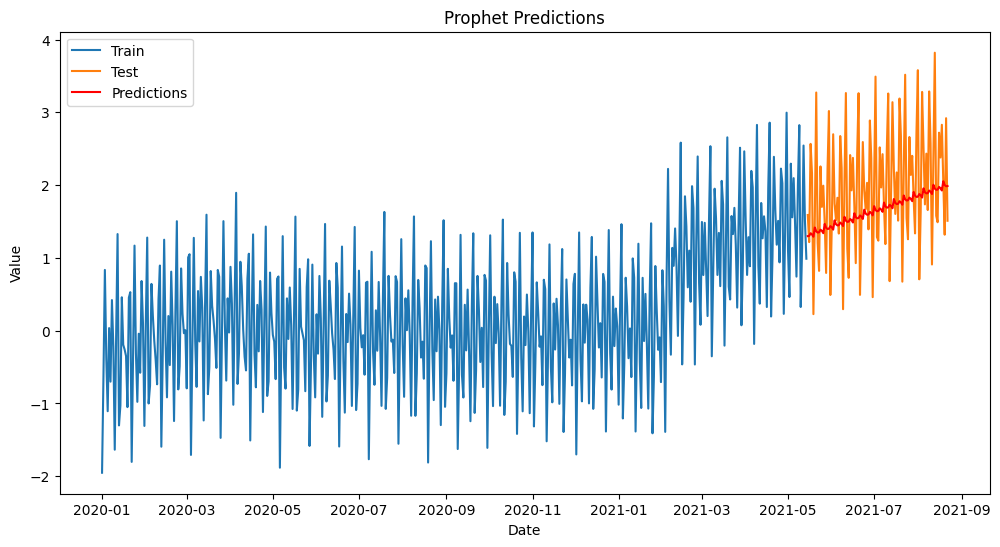

RMSE: 0.8589362857099176
MAE: 0.6996262959875515


In [32]:
dates = pd.date_range(start='2020-01-01', periods=len(pts_train) + len(pts_test), freq='D')
dates_train = dates[:len(pts_train)]
dates_test = dates[len(pts_train):]

data = pd.DataFrame({'ds': dates_train, 'y': pts_train})
model = Prophet()
model.fit(data)

future = model.make_future_dataframe(periods=len(pts_test))
forecast = model.predict(future)

plt.figure(figsize=(12, 6))
plt.plot(dates_train, pts_train, label='Train')
plt.plot(dates_test, pts_test, label='Test')
plt.plot(dates_test, forecast['yhat'][-len(pts_test):], label='Predictions', color = 'red')
plt.title('Prophet Predictions')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

rmse = np.sqrt(mean_squared_error(pts_test, forecast['yhat'][-len(pts_test):]))
mae = mean_absolute_error(pts_test, forecast['yhat'][-len(pts_test):])

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

We can clearly see that `Prophet` and `Optimized ARIMA` gave the best results with predictions closest to the real ones which is really interesting considering that `Prophet` had the worst results compared to `ARIMA` and `Exponential smoothing` on stocks.